## *Required Libraries*

In [ ]:
from keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.applications import DenseNet121
from keras.layers import Input,Rescaling,Resizing,Flatten,Dense
from keras.models import Sequential
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
import numpy as np
from keras.models import save_model,load_model
from keras.preprocessing.image import load_img,img_to_array

## *Loading Our Dataset*

*Training Dataset*

In [38]:
train_ds=image_dataset_from_directory('Dataset/train/Grape',
                                      batch_size=32,
                                      image_size=(256,256),
                                      shuffle=True)

Found 7222 files belonging to 4 classes.


*Valiation Dataset*

In [39]:
val_ds=image_dataset_from_directory('Dataset/valid/Grape',
                                      batch_size=32,
                                      image_size=(256,256),
                                      shuffle=True)

Found 1805 files belonging to 4 classes.


In [40]:
classes=train_ds.class_names
classes

['Black Rot', 'Esca', 'Healthy', 'Leaf Blight']

In [41]:
training_class=train_ds.class_names
training_class

['Black Rot', 'Esca', 'Healthy', 'Leaf Blight']

In [42]:
validation_class=val_ds.class_names
validation_class

['Black Rot', 'Esca', 'Healthy', 'Leaf Blight']

In [43]:
print(len(train_ds))
print(len(val_ds))

226
57


In [44]:
for img,label in train_ds.take(1):
    print(img.shape)
    print(label.numpy())

(32, 256, 256, 3)
[3 0 3 2 0 0 2 3 3 3 1 2 1 2 1 2 3 0 2 3 3 3 0 1 1 0 3 1 2 3 0 2]


## *Visualizing Some Images*

*Training Images*

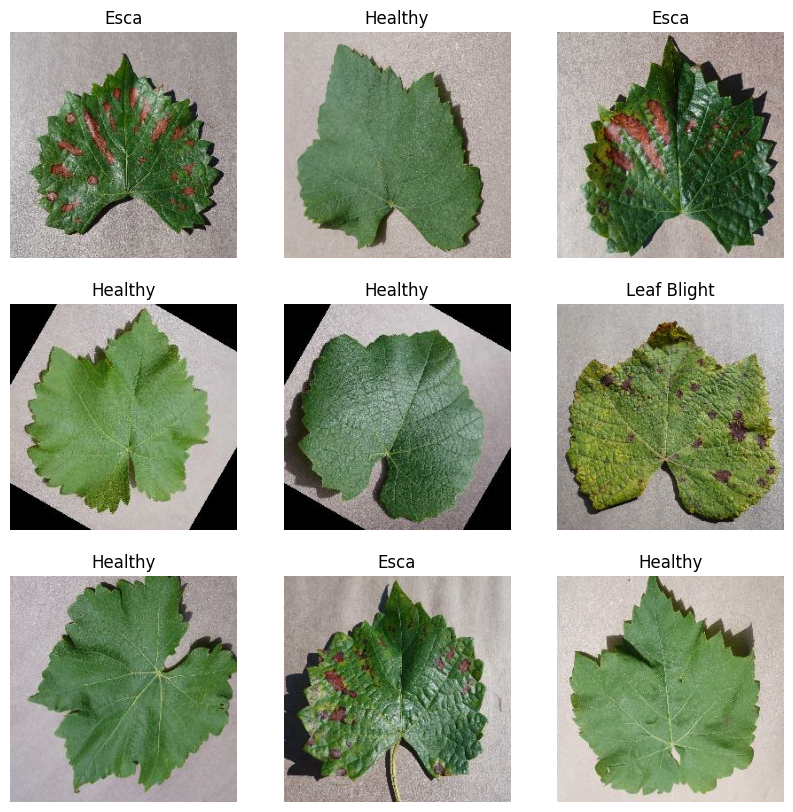

In [45]:
plt.figure(figsize=(10,10))
for image,label in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.axis('off')
        plt.title(training_class[label[i]])

*Validation Images*

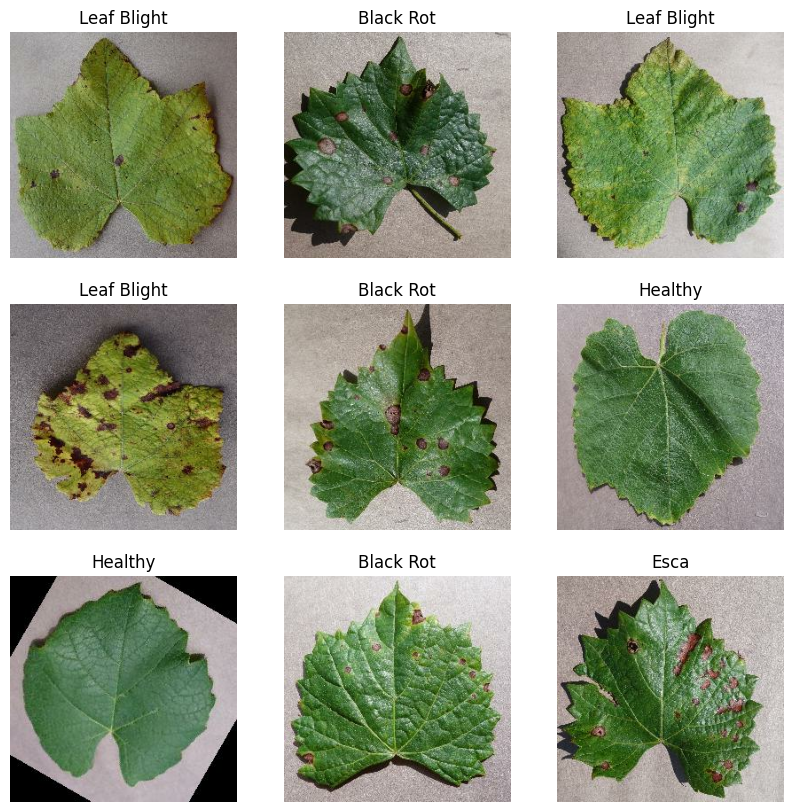

In [46]:
plt.figure(figsize=(10,10))
for image,label in val_ds.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.axis('off')
        plt.title(validation_class[label[i]])

In [47]:
# This will help to train our model quicker
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## *Building Our Model*

In [48]:
# Loading pre-trained DenseNet121 model (without including the top classification layers)
base_model=DenseNet121(include_top=False,input_shape=(256,256,3))

In [49]:
base_model.trainable=False # Freezing the layers of the base model

In [50]:
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 262, 262, 3)          0         ['input_3[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 128, 128, 64)         9408      ['zero_padding2d_2[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1/conv[0][0]']

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.78911 to fit



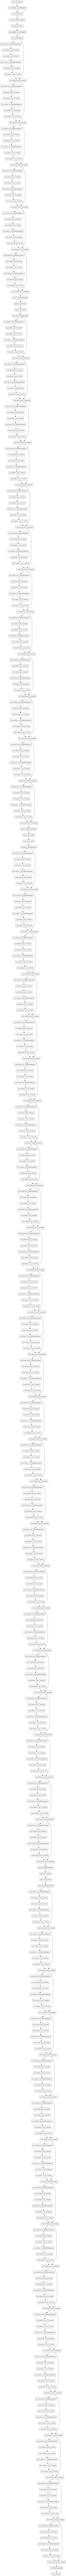

In [51]:
plot_model(base_model)

*Creating a rescaling and resizing layer*

In [52]:
rescaling_layer=Rescaling(1.0/255) # Adding a rescaling layer to scale pixel values to the range [0, 1]

resizing_layer=Resizing(256,256) # Add a resizing layer to resize images to (256, 256)

*Adding Dense Layer*

In [53]:
model=Sequential()
model.add(Input(shape=(256,256,3)))
model.add(resizing_layer)
model.add(rescaling_layer)
model.add(base_model)
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(len(classes), activation='softmax'))

In [54]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 256, 256, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 densenet121 (Functional)    (None, 8, 8, 1024)        7037504   
                                                                 
 flatten_1 (Flatten)         (None, 65536)             0         
                                                                 
 dense_2 (Dense)             (None, 64)                4194368   
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
Total params: 11232132 (42.85 MB)
Trainable params: 41

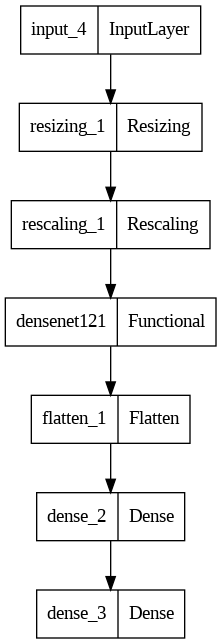

In [55]:
plot_model(model)

## *Model Compilation*

In [56]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

## *Using Early Stopping*

In [57]:
early_stopping=EarlyStopping(monitor='val_loss',patience=3)

## *Model Training*

In [58]:
history=model.fit(train_ds,epochs=50,batch_size=32,validation_data=val_ds,callbacks=[early_stopping])

Epoch 1/50
226/226 [==============================] - 65s 216ms/step - loss: 0.8441 - accuracy: 0.9286 - val_loss: 0.0387 - val_accuracy: 0.9922
Epoch 2/50
226/226 [==============================] - 33s 145ms/step - loss: 0.0276 - accuracy: 0.9916 - val_loss: 0.0502 - val_accuracy: 0.9928
Epoch 3/50
226/226 [==============================] - 33s 147ms/step - loss: 0.0320 - accuracy: 0.9920 - val_loss: 0.0476 - val_accuracy: 0.9878
Epoch 4/50
226/226 [==============================] - 33s 146ms/step - loss: 0.0144 - accuracy: 0.9965 - val_loss: 0.0490 - val_accuracy: 0.9889


## *Model Evaluation*

In [59]:
loss, accuracy = model.evaluate(val_ds,verbose=0)
print("Accuracy",accuracy)
print("Loss",loss)

Accuracy 0.9889196753501892
Loss 0.04897786304354668


## *Visualizing Accuracy and Loss*

In [60]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

In [61]:
epochs_completed = len(history.history['loss'])
epochs_completed

4

*Training Accuracy vs Validation Accuracy*

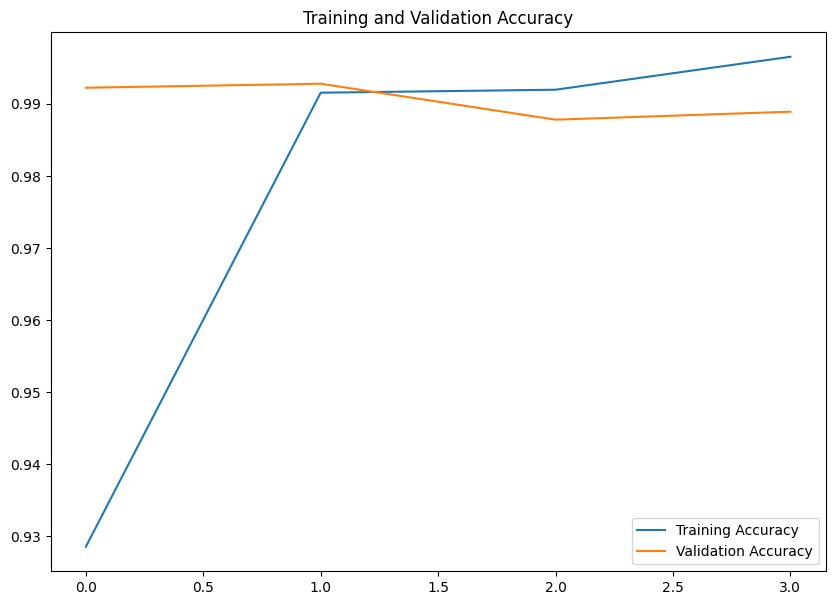

In [62]:
plt.figure(figsize=(10,7))
plt.plot(range(epochs_completed),acc,label='Training Accuracy')
plt.plot(range(epochs_completed),val_acc,label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

*Training Loss vs Validation Loss*

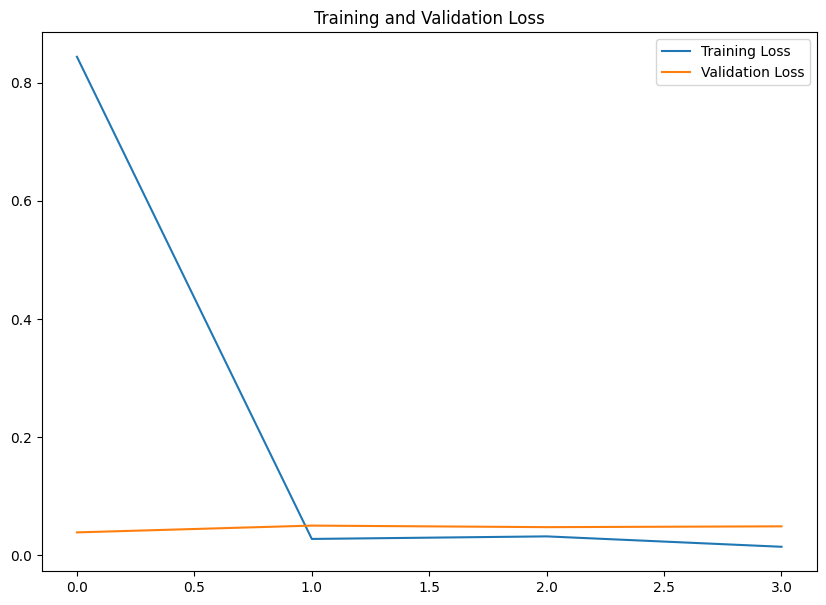

In [63]:
plt.figure(figsize=(10,7))
plt.plot(range(epochs_completed),loss,label='Training Loss')
plt.plot(range(epochs_completed),val_loss,label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

## *Saving Our Model*

In [ ]:
save_model(model,'grape_model.h5')

## *Loading Our Model*

In [ ]:
model=load_model('grape_model.h5')

## *Model Testing*

Esca


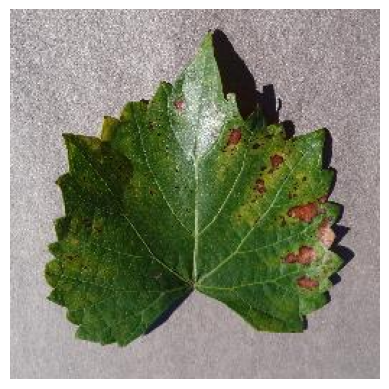

In [6]:
image=load_img('Dataset/test/GrapeEsca.JPG')
image_array=img_to_array(image)
expanded_image=np.expand_dims(image_array,axis=0)

pred=model.predict(expanded_image,verbose=0)
result=classes[np.argmax(pred[0])]
print(result)
plt.imshow(image)
plt.axis('off')
plt.show()